<a target="_blank" href="https://colab.research.google.com/github/paulotguerra/QXD0178/blob/main/03.E0-Exercicio-Agrupamento-de-Dados.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## QXD0178 - Mineração de Dados
# Visualização de Dados
**Professor:** Paulo de Tarso Guerra Oliveira ([paulodetarso@ufc.br](mailto:paulodetarso@ufc.br))
# <center> Lista de Exercícios: Visualização de Dados </center>

## Processo de Visualização de Dados

Dataset: [311 Complaint Data](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9)

Sua proposta deve delinear estas quatro dimensões:

- **Sua pergunta de pesquisa**.
  - _"Quais os melhores locais para habitação segundo metricas de qualidade de vida"_
- **Seu público**.
  - Possiveis novos locatarios de habitações, clientes que nunca residiram na cidade, especuladores imobiliarios e possiveis compradores fisicos.
- **Uma descrição escrita de suas visualizações**. Explique suas visualizações em termos que um novato em dados entenderia. Em uma frase para um parágrafo, que conclusão devo tirar de sua visualização?
- **Uma explicação dos dados e decisões de design que você tomou**. Esta seção deve ilustrar o que você fez e por que fez. Por que você escolheu o tipo de gráfico/gráfico/visualização que fez? Como essa escolha representa melhor os dados e aborda sua pergunta? Por meio dessa explicação, você ilustrará que as decisões que tomou foram intencionais e como elas contribuem para o projeto. Você também deve explicar quaisquer limitações que encontrou e quaisquer compromissos subsequentes que fez com os dados ou seu design.


In [2]:
import re
from typing import Final

import folium
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import zeros
from pandas import read_csv, to_datetime, set_option, Series

set_option('display.max_columns', None)
URL: Final[str] = 'https://data.cityofnewyork.us/resource/erm2-nwe9.csv'
N_ROWS: Final[int] = 300000

### Notas:
- facility_type tem menos de 6000 valores
- agency é só um acronimo
- open_data_channel_type não é util para a analise de imoveis
- vehicle_type, taxi_company_borough, taxi_pick_up_location, bridge_highway_name, bridge_highway_direction, road_ramp e bridge_highway_segment também não são uteis, mas estão atreladas as linhas, então devem ser eliminadas

In [3]:
df = read_csv(URL + f'?$limit={N_ROWS}', low_memory=False)

df['created_date'] = to_datetime(df['created_date'], format='%Y-%m-%dT%H:%M:%S.%f')
df['closed_date'] = to_datetime(df['closed_date'], format='%Y-%m-%dT%H:%M:%S.%f')
df['due_date'] = to_datetime(df['due_date'], format='%Y-%m-%dT%H:%M:%S.%f')
df['resolution_action_updated_date'] = to_datetime(df['resolution_action_updated_date'], format='%Y-%m-%dT%H:%M:%S.%f')

df['descriptor'] = df['descriptor'].str.lower()
df['location_type'] = df['location_type'].str.lower()

df.drop(columns=['facility_type','agency','open_data_channel_type'], inplace=True)
df.rename(columns={'bbl': 'borough_block_n_lot'}, inplace=True)

In [6]:
df['vehicle_type'].value_counts()

vehicle_type
Car                        7610
SUV                        1528
Other                       832
Truck                       825
Van                         805
Car Service                  68
Ambulette / Paratransit       2
Green Taxi                    1
Name: count, dtype: int64

In [5]:
def extract_coordinates(text:str) -> tuple[float, float] | tuple[None, None]:
    """
    Find the pattern (number, number) in the text

    Args:
        text (str): string with coordinates in the format (number, number)

    Returns:
        tuple[float, float] | tuple[None, None]: tuple with the coordinates or None
    """
    if text == '' or text is None: 
        return None, None
    try:
        if (finds := re.search(r'\(([0-9.-]+),\s*([0-9.-]+)\)', text)):
            return float(finds.group(1)), float(finds.group(2))
            
        else:
            return None, None
    except TypeError:
        return None, None

In [6]:
df['latitude'], df['longitude'] = zip(*df['location'].map(extract_coordinates))
df.drop(columns=['location'], inplace=True)

In [7]:
category_mappings = {
    'Noise': r'noise|loud|sound',
    'Parking & Vehicle': r'parking|driveway|vehicle|traffic|taxi|car|bus|transportation|for hire|bike|scooter|roller',
    'Property Maintenance': r'heat|hot water|plumbing|paint|plaster|door|window|leak|floor|stair|elevator|appliance|boiler|electrical|mold',
    'Sanitation': r'sanit|dirt|clean|dump|collection|rodent|trash|garbage|litter|basket|waste|sewage|disposal|food poison',
    'Street & Infrastructure': r'street|water system|light|sidewalk|sewer|highway|curb|sign|broken|damaged|bridge|road',
    'Public Safety': r'drug|police|safety|emergency|fire|ert|iad',
    'Environmental': r'air quality|water quality|water conservation|environment',
    'Vegetation & Natural': r'tree|plant|snow|ice|stump|branch|natural|wood',
    'Commercial': r'vendor|consumer|business|commercial|store|shop|food establishment|restaurant',
    'Quality of Life': r'graffiti|encampment|panhandl|smoking|drinking|post|firework|homeless|urinat|disorderly|drinking',
    'Animal': r'animal|dog|pet|bee|wasp|pigeon',
    'Public Facilities': r'shelter|rack|bench|toilet|ferry|municipal|facility|building|link|construction'
}
def categorize_complaint(complaint:str) -> str:
    """
    Group complaint types into broader categories to reduce the number of classes.
    
    Args:
        complaint (str): Complaint class name
        
    Returns:
        str: complaint super class
    """    
    for category, pattern in category_mappings.items():
        if re.search(pattern, complaint.lower()):
            return category
    
    return 'Other'

df['complaint_type'] = df['complaint_type'].str.lower()
df['complaint_group'] = df['complaint_type'].apply(categorize_complaint)

In [8]:
category_mapping = {
    "Residential": [
        'residential building',
        'residential building/house',
        '3+ family apt. building',
        '1-2 family dwelling',
        '3+ family apartment building',
        '1-2 family mixed use building',
        '1-3 family dwelling',
        'apartment',
        'private house',
        'single room occupancy (sro)',
        'residence',
        'residential',
        'common area',
        'hallway',
        'lobby',
        'stairwell',
        'house and store',
    ],
    "Commercial Areas": [
        'store/commercial',
        'club/bar/restaurant',
        'restaurant/bar/deli/bakery',
        'business',
        'retail store',
        'commercial building',
        'comercial',
        'food establishment or vendor',
        'tattoo parlor',
        'catering service',
        'groomer',
        "veterinarian's office",
        'mixed use',
        'mixed use building'
    ],
    "Public and Recreational Spaces": [
        'park',
        'park/playground',
        'public garden',
        'public school',
        'private school',
        'school',
        'school/pre-school',
        'day care/nursery',
        'government building',
        'non-profit',
        'homeless shelter',
        'hospital',
        'medical facility',
        'sauna',
        'pool',
        'house of worship',
        'vacant lot',
        'vacant building'
    ],
    "Transportation-Related": [
        'street/sidewalk',
        'street',
        'sidewalk',
        'highway',
        'taxi',
        'bus stop shelter',
        'subway',
        'subway station',
        'roadway tunnel',
        'bridge',
        'overpass',
        'terminal',
        'intersection',
        'traffic island or median',
        'crosswalk',
        'street/curbside',
        'vehicle lane',
        'gutter',
        'catch basin/sewer'
    ],
    "Construction and Industrial": [
        'construction site',
        'building (non-residential)',
        'lot',
        'parking lot/garage',
        'parking lot'
    ],
    "Other/Miscellaneous": [
        'above address',
        'other (explain below)',
        'other',
        'other (explain in complaint details)',
        'food cart vendor',
        'green cart vendor',
        'street fair vendor',
        'kennel/animal shelter',
        'ferry',
        'cafeteria - private school',
        'cafeteria - private'
    ]
}
def categorize_location(location:str) -> str:
    for category, locations in category_mapping.items():
        if location in locations:
            return category
    return "Unknown"

df['location_type_group'] = df['location_type'].apply(categorize_location)

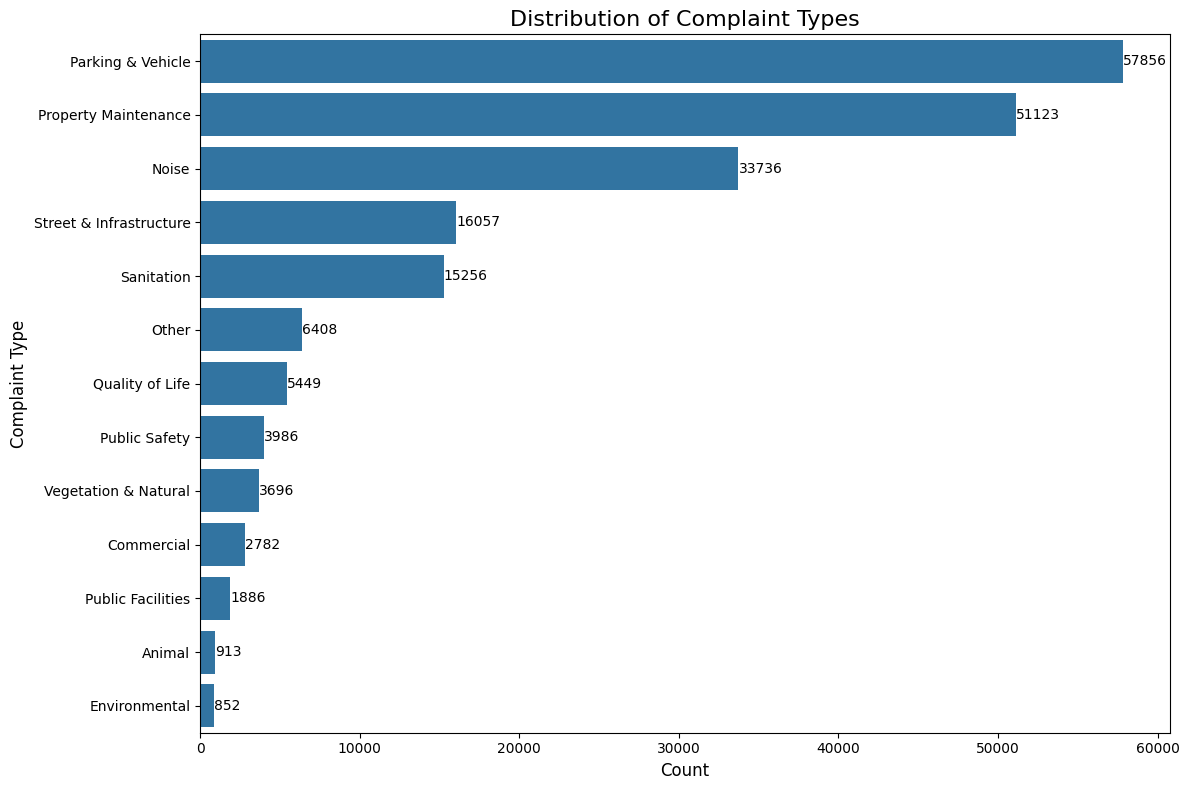

In [31]:
complaint_counts = df['complaint_group'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=complaint_counts.values, y=complaint_counts.index)
plt.title('Distribution of Complaint Types', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Complaint Type', fontsize=12)

for i, count in enumerate(complaint_counts.values):
    plt.text(count + 0.5, i, str(count), va='center')

plt.tight_layout()
plt.show()

In [32]:
grouped_df = df.groupby(['complaint_group', 'complaint_type']).size().reset_index(name='count')
categories = df['complaint_group'].value_counts().index.tolist()

/tmp/ipykernel_163000/3561346754.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', 20)


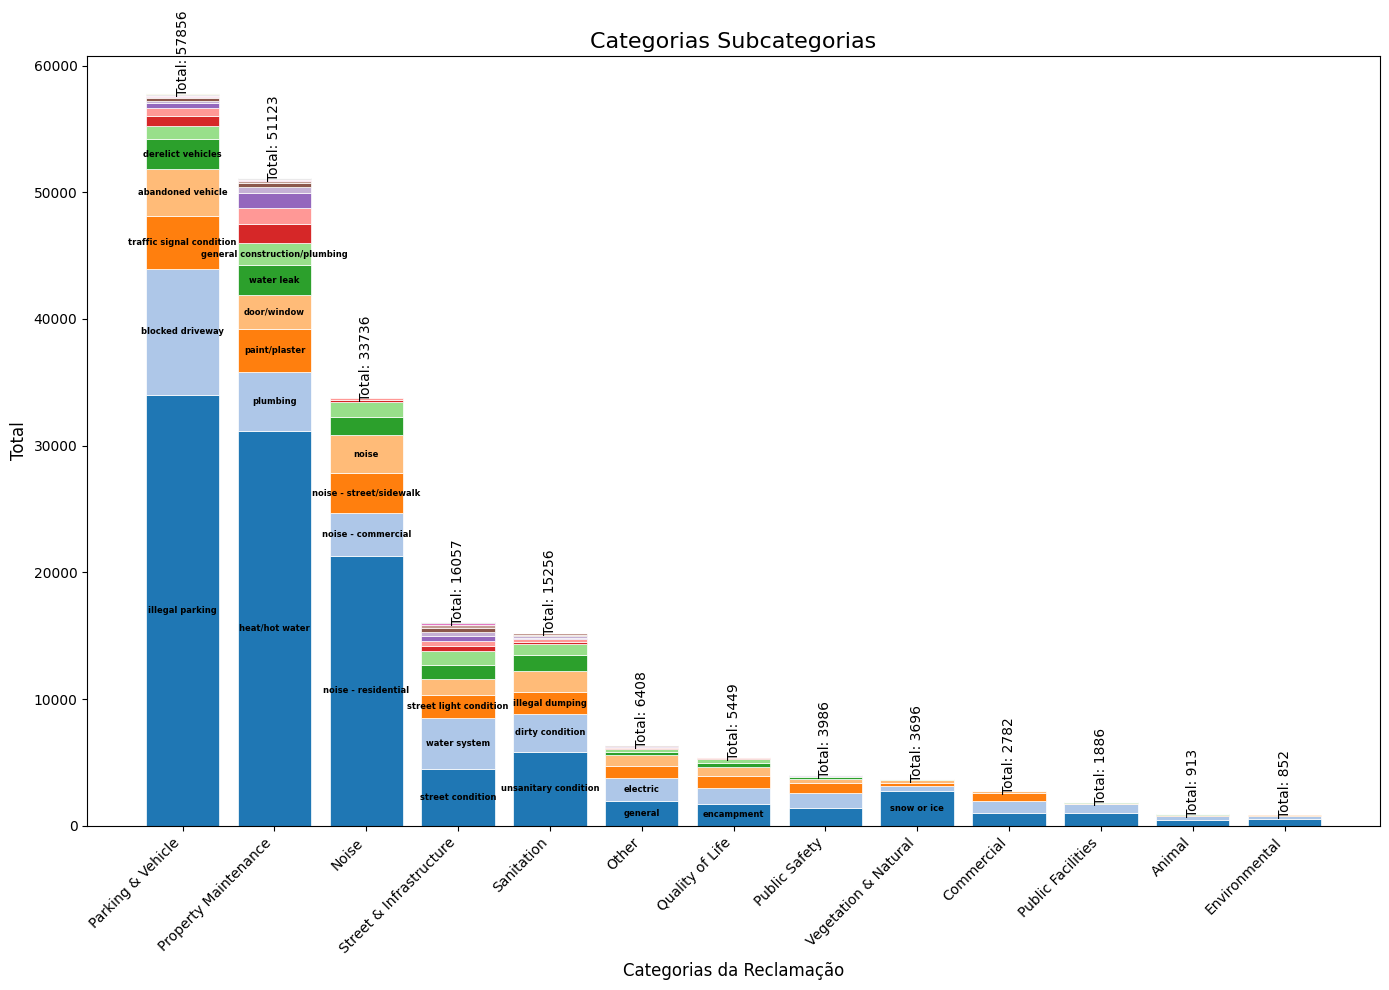

In [33]:
fig, ax = plt.subplots(figsize=(14, 10))
color_map = plt.cm.get_cmap('tab20', 20)
x_offset = zeros(len(categories))

handles, labels = [], []
for i, category in enumerate(categories):
    for j, (_, row) in enumerate(grouped_df[grouped_df['complaint_group'] == category].sort_values('count', ascending=False).iterrows()):
        count = row['count']
        
        bar = ax.bar(i, count, 0.8, bottom=x_offset[i], color=color_map(j % 20), edgecolor='white', linewidth=0.5)

        if count > max(grouped_df['count']) * 0.05:
            ax.text(i, x_offset[i] + count/2, str(row['complaint_type']), ha='center', va='center', color='black', fontsize=6, fontweight='bold')
        
        x_offset[i] += count
        
        if i == 0:
            handles.append(bar)
            labels.append(str(row['complaint_type']))

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_title('Categorias Subcategorias', fontsize=16)
ax.set_ylabel('Total', fontsize=12)
ax.set_xlabel('Categorias da Reclamação', fontsize=12)

for i, category in enumerate(categories):
    ax.text(i, x_offset[i] + 5, f'Total: {int(x_offset[i])}', ha='center', fontsize=10, rotation=90)

plt.tight_layout()
plt.show()

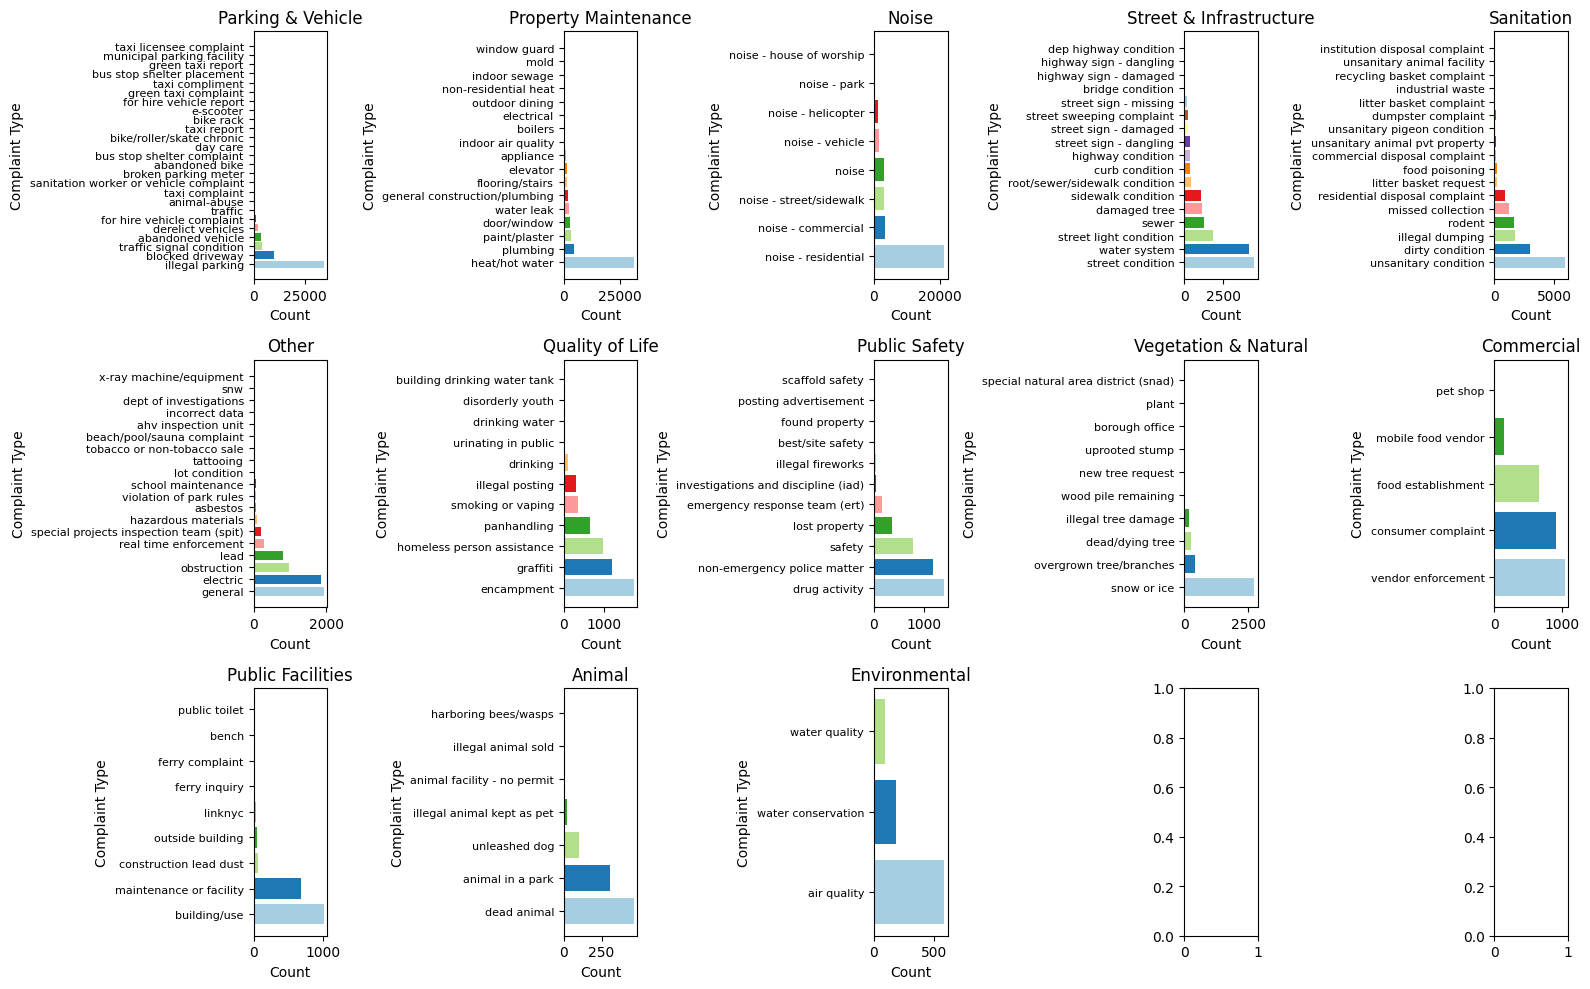

In [34]:
fig, axes = plt.subplots(3, 5, figsize=(16, 10))
axes = axes.flatten()

for i, category in enumerate(categories):
    ax = axes[i]
    sub_df = grouped_df[grouped_df['complaint_group'] == category].sort_values('count', ascending=False)

    ax.barh(sub_df['complaint_type'], sub_df['count'], color=plt.cm.Paired.colors)
    ax.set_title(category, fontsize=12)
    ax.set_xlabel("Count")
    ax.set_ylabel("Complaint Type")
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

In [ ]:
data = df[df['complaint_group'] == 'Animal'][['complaint_type','latitude','longitude']].dropna()
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for local in data.itertuples():
    folium.Marker(
        location=[local.latitude, local.longitude],
        popup=local.complaint_type,
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(map_nyc)

map_nyc.save("../reports/nyc_map_animal.html")
map_nyc

## Key Complaints for Life Quality

- embora os items de environmental seja bem importantes, eles são mt poucos e estão mt espalhados pra fazer algum sentido
- o mesmo se aplica aos problemas relacionados a animais

In [ ]:
high_impact_complaints = [
    'snow or ice',
    'drug activity',
    'encampment', # acho q isso são sem tetos, gringo preconceituoso
    'lead', # possivel envenenamento por chumbo, talve na tinta
    'eletric', # problemas eletricos em geral.   
    'unsanitary condition',
    'dirty condition',
    'street condition',
    'water system',
    'street light condition',
    'noise - residential',
    'noise - commercial'
    'noise - street/sidewalk',
    'head/hot water',
    'plumbing',
    'blocked driveway'
]
data = df[df['complaint_type'].isin(high_impact_complaints)][['complaint_type','latitude','longitude']].dropna()
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for local in data.itertuples():
    folium.Marker(
        location=[local.latitude, local.longitude],
        popup=local.complaint_type,
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(map_nyc)

map_nyc.save("../reports/nyc_map_bad_places.html")
map_nyc

### **Critérios de Avaliação**  

**1. Escolha Apropriada de Visualização (4 pontos)**  
- O tipo de visualização está alinhado com a questão da pesquisa.  
- O gráfico ou tabela escolhidos representam os dados com precisão e de forma adequada.  

**2. Comunicação Eficaz (2 pontos)**  
- A mensagem principal da análise é comunicada de forma clara e compreensível.  
- Os dados são apresentados com precisão, sem distorções ou interpretações enganosas.  

**3. Design e Estética (2 pontos)**  
- Todos os elementos da visualização têm uma função comunicativa e não são apenas decorativos.  
- A organização do notebook e o layout das visualizações seguem uma estrutura lógica e intencional.  
- Títulos, legendas e rótulos são informativos, bem posicionados e utilizam tamanhos e grafias apropriados.  

**4. Qualidade da Documentação (2 pontos)**  
- O notebook fornece um contexto claro que torna as visualizações mais compreensíveis e acessíveis.  
- O notebook explica o propósito da análise e as decisões tomadas no processo de criação.  
- Todos os componentes essenciais (pergunta de pesquisa, definição do público, explicação das escolhas, análise das visualizações e próximos passos) estão incluídos.  
- As decisões seguem boas práticas de visualização de dados.  